# Лабораторная работа №3
## Выполнила Мосева Алеся

# ЛР3. NB, LR, SVM

In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Создадим DataFrame train_df из CSV train.csv
train_df = pd.read_csv("./train.csv")

# Создадим DataFrame test_df из CSV test.csv
test_df = pd.read_csv("./test.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Посчитайте количество объектов в DF train и test
print(train_df['PassengerId'].count())
print(test_df['PassengerId'].count())

891
418


<font color=red>  Примечание. В тестовых данных нет целевой переменной (т. е. столбец «Survival» отсутствует), поэтому цель состоит в том, чтобы предсказать эту переменную с использованием различных алгоритмов машинного обучения, таких как логистическая регрессия. </font>

In [4]:
# Проверьте, есть ли в данных train_df пропущенные значения
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Давайте разберемся с графиой "Age"
Ответьте на вопросы и сделайте следующие дейтсвия

Сколько процентов значений пропущено?
Найдите медиану и среднее значение переменной.
Постойте гистаграмму.
Какое значение больше: медиана или среднее?

In [5]:
train_df['Age'].isna().sum() / train_df['PassengerId'].count() * 100

19.865319865319865

In [6]:
print(train_df['Age'].median())
print(train_df['Age'].mean())

28.0
29.69911764705882


Больше среднее значение, чем медиана

Text(0, 0.5, 'Count')

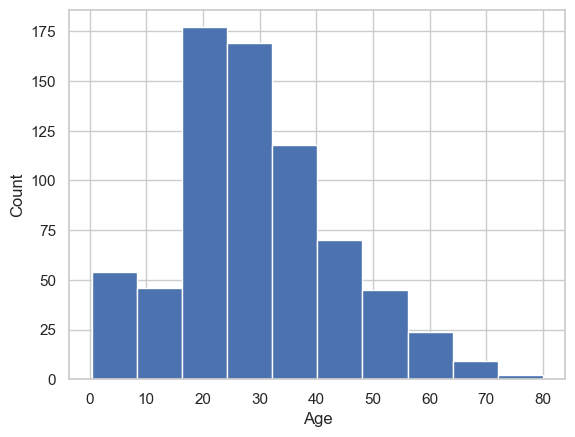

In [7]:
import matplotlib.pyplot as plt
plt.hist(train_df['Age'])
plt.xlabel('Age')
plt.ylabel('Count')

Так как график распределения смещён вправа, использование среднего значения может дать нам необъективные результаты из-за заполнения возрастов, которые старше желаемого. Чтобы справиться с этим, мы будем использовать медиану для вменения пропущенных значений.

Давайте разберемся с графиой "Cabin"

Сколько процентов значений пропущено?

In [8]:
train_df['Cabin'].isna().sum() / train_df['PassengerId'].count() * 100

77.10437710437711

<font color=green>  Если в столбце больше половины пропусков, то он не информативен для нас. В дальнейшем мы его уберем </font>

Давайте разберемся с графиой "Embarked"

Сколько процентов значений пропущено?

In [9]:
train_df['Embarked'].isna().sum() / train_df['PassengerId'].count() * 100

0.22446689113355783

In [10]:
train_data = train_df.copy()

Основываясь на оценке отсутствующих значений в наборе данных, внесите в данные следующие изменения:

Если в строке отсутствует «Age», вставьте средний возраст.
Если отсутствует «Embarked», замените его на наиболее распространенный порт посадки.
Удалите столбец "Cabin"

In [11]:
mean_age = train_df['Age'].mean()
train_data['Age'] = train_data['Age'].fillna(mean_age)
train_data['Age'].isna().sum()

0

In [12]:
fill_embarked= train_data['Embarked'].value_counts().idxmax()
train_data['Embarked'] = train_data['Embarked'].fillna(fill_embarked)
train_data['Embarked'].isna().sum()

0

In [13]:
train_data = train_data.drop('Cabin', axis=1)

Выполните проверку на пустые значения. Таковых остаться не должно

In [14]:
train_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Согласно словарю данных Kaggle, и SibSp, и Parch относятся к путешествиям с семьей. Для простоты (и для учета возможной мультиколлинеарности) я объединим влияние этих переменных в один категориальный предиктор: путешествовал ли этот человек один или нет (0 или 1).
Не забудьте удалить SibSp и Parch (Пока работаем с train_data)

In [15]:
train_data['TravelAlone'] = np.where((train_data['SibSp'] + train_data['Parch']) > 0, 0, 1)
train_data = train_data.drop(['SibSp', 'Parch'], axis=1)

также создадим категориальные переменные для класса пассажира ("Pclass"), пола ("Sex") и порта посадки ("Embarked").
Используем функцию pd.get_dummies
Не забудьте удалить колонки, из которых делаете dummie-переменные

In [16]:
train_data = pd.get_dummies(train_data, columns=['Pclass', 'Sex', 'Embarked'])
train_data

,PassengerId,Survived,Name,Age,Ticket,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.000000,A/5 21171,7.2500,0,False,False,True,False,True,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000000,PC 17599,71.2833,0,True,False,False,True,False,True,False,False
2,3,1,"Heikkinen, Miss. Laina",26.000000,STON/O2. 3101282,7.9250,1,False,False,True,True,False,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000000,113803,53.1000,0,True,False,False,True,False,False,False,True
4,5,0,"Allen, Mr. William Henry",35.000000,373450,8.0500,1,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.000000,211536,13.0000,1,False,True,False,False,True,False,False,True
887,888,1,"Graham, Miss. Margaret Edith",19.000000,112053,30.0000,1,True,False,False,True,False,False,False,True
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",29.699118,W./C. 6607,23.4500,0,False,False,True,True,False,False,False,True
889,890,1,"Behr, Mr. Karl Howell",26.000000,111369,30.0000,1,True,False,False,False,True,True,False,False


Теперь примените те же изменения к тестовым данным.

Применим то же значение для «Возраст» в тестовых данных, что и для моих данных обучения (если отсутствует, возраст = 28).
Уберем «Cabin» из тестовых данных
В переменной порта "Embarked" не было пропущенных значений.
Добавим dummie переменные.
Наконец, заполним 1 пропущенное значение для «Fare» с медианой 14,45.

In [25]:
test_data = test_df.copy()
test_data['Age'] = test_data['Age'].fillna(28)
# test_data = test_data.drop('Cabin')
test_data = pd.get_dummies(test_data, columns=['Pclass', 'Sex', 'Embarked'])
test_data = test_data.drop('Cabin', axis=1)
test_data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,False,False,True,False,True,False,True,False
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,False,False,True,True,False,False,False,True
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,False,True,False,False,True,False,True,False
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,False,False,True,False,True,False,False,True
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,False,False,True,True,False,False,False,True


Оцените выживаемость Пассажиров до 16 лет

In [27]:
train_data.loc[train_data['Age'] <= 16, 'Survived'].mean() * 100

55.00000000000001

Учитывая выживаемость пассажиров моложе 16 лет,включим в свой набор данных еще одну категориальную переменную: «IsMinor». Значение 1 - если меньше 16 лет, 0 - если больше

In [28]:
train_data['IsMinor']=np.where(train_data['Age'] <  16, 1, 0)

Определите самый безопасный класс
Определите, кому удаолсь выжить с большей вероятностью: кто путешествовал в одиночку или нет

In [36]:
print(f'First class: {train_data.loc[train_data["Pclass_1"].isin([1])]["Survived"].sum() / train_data["Survived"].count() * 100} ')
print(f'Second class: {train_data.loc[train_data["Pclass_2"].isin([1])]["Survived"].sum() / train_data["Survived"].count() * 100}')
print(f'Third class: {train_data.loc[train_data["Pclass_3"].isin([1])]["Survived"].sum() / train_data["Survived"].count() * 100}')
print(f'Travel alone: {train_data.loc[train_data["TravelAlone"].isin([1])]["Survived"].sum() / train_data["Survived"].count() * 100}')

First class: 15.26374859708193 
Second class: 9.764309764309765
Third class: 13.35578002244669
Travel alone: 18.29405162738496


Самый безопасный класс: 1


##  Выбор признаков для анализа


### Рекурсивное устранение признаков

рекурсивное исключение функций (RFE) заключается в выборе функций путем рекурсивного рассмотрения все меньших и меньших наборов функций. Во-первых, оценщик обучается на начальном наборе признаков, и важность каждого признака определяется либо с помощью атрибута «coef_», либо с помощью атрибута «feature_importances_». Затем наименее важные функции удаляются из текущего набора функций. Эта процедура рекурсивно повторяется для сокращенного набора до тех пор, пока в конечном итоге не будет достигнуто желаемое количество функций для выбора.

Изучите материалы ниже

 <br>
 https://www.helenkapatsa.ru/kross-validatsiia/ <br>
 https://www.codecamp.ru/blog/cross-validation-k-fold/ <br>
http://scikit-learn.org/stable/modules/feature_selection.html <br>

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = train_data[cols]
y = train_data['Survived']
# Создайте logreg и вычислите важность функций
model = LogisticRegression()
# создайте модель RFE и выберите 8 атрибутов
rfe = RFE(model, n_features_to_select=8)
rfe = rfe.fit(X, y)
# резюмируем  выбор атрибутов
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


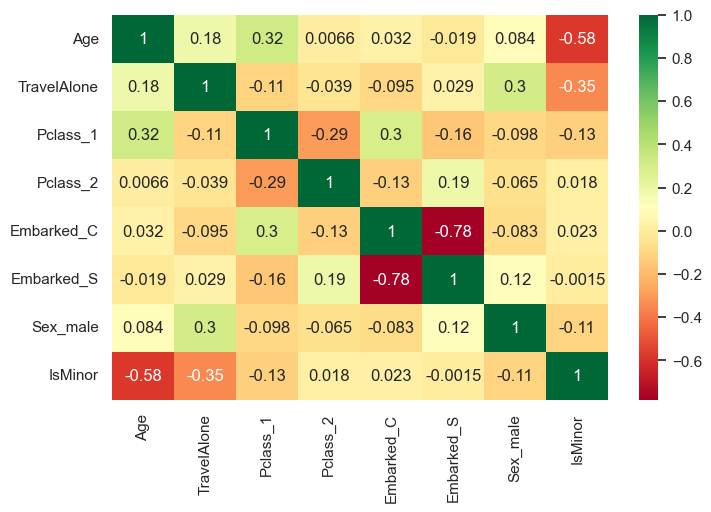

In [39]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = train_data[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

## представьте, перед вами стоит задача оценки качества работы модели машинного обучения и сравнения таких моделей межд собой

идея: разделение датасета на выборку для обучения и тестирования

### Оценка модели на основе простого разделения train/test с использованием функции `train_test_split()`

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X = train_data[Selected_features]
y = train_data['Survived']

# можно использовать разделение обучения/тестирования с разными значениями random_state
# мы можем изменить значения random_state, которые изменят показатели точности
# результаты сильно меняются, поэтому результаты тестирования являются оценкой с высокой дисперсией
# test_size разделяет выборку на тестовую и убучающую в соотношении 20/80
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.788
LogisticRegression log_loss is 0.503
LogisticRegression auc is 0.838


### Оценка модели на основе K-fold cross-validation с использованием функции cross_val_score()

In [41]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression()
# Используем cross_val_score function
# Мы передаём полные X and y, а не X_train и y_train, функция сама разбивает данные
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} в качестве метрик оценивания результата (есть и другие)
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.801
LogisticRegression average log_loss is 0.454
LogisticRegression average auc is 0.850


### Оценка модели на основе K-fold cross-validation с использованием функции cross_validate()

In [42]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.801 (+/-0.028)
LogisticRegression average log_loss: 0.454 (+/-0.039)
LogisticRegression average auc: 0.850 (+/-0.029)



Формула Байеса


$$
P (A | B) = \frac{P ( B ∣ A ) P ( A )}{P ( B )}
$$


    где

        P ( A ) P(A) — априорная вероятность гипотезы A (смысл такой терминологии см. ниже);
        P ( A ∣ B ) — вероятность гипотезы A при наступлении события B (апостериорная вероятность);
        P ( B ∣ A )  — вероятность наступления события B при истинности гипотезы A;
        P ( B ) P(B) — полная вероятность наступления события B.



In [43]:
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [49]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
print()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [45]:

def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))
    
cross_validate(classifier, (X_train, y_train), (X_test, y_test))

Model metrics
Accuracy  Train: 0.78, Validation: 0.77
Recall    Train: 0.68, Validation: 0.76
Precision Train: 0.78, Validation: 0.68


## SVM

In [46]:
from sklearn.svm import SVC
# Declaring the SVC with no tunning
classifier = SVC()

# Fitting the data. This is where the SVM will learn
classifier.fit(X_train, y_train)

# Predicting the result and giving the accuracy
score = classifier.score(X_test, y_test)

print(score)

0.5698324022346368


In [48]:
#Посчитайте score, если train set будет состоять только из 3 переменных: ['Sex', 'Age', 'Pclass']
selected_fields = ['Age', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3']
X = train_data[selected_fields]
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = SVC()

classifier.fit(X_train, y_train)

classifier.score(X_test, y_test)

0.5977653631284916